In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# --- Define Paths --- #
PROCESSED_DATA_DIR = 'processed_data'
FEATURES_DF_PATH = os.path.join(PROCESSED_DATA_DIR, 'extracted_features.pkl')

In [3]:
# --- Section 1: Data Loading and Preprocessing ---
# =================================================

# Attempt to load the data
try:
    data = pd.read_pickle(FEATURES_DF_PATH)
except FileNotFoundError:
    print(f"Error: Extracted features not found at {FEATURES_DF_PATH}.")
    print("Please ensure your feature extraction script has been run.")
    exit()

# Features and labels
X = data.drop(columns=['emotion'])
Y = data['emotion']

print("Emotion distribution before balancing:")
print(Y.value_counts())

# Train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
print(f"\nTraining set size: {len(x_train)}")
print(f"Testing set size: {len(x_test)}")


# -----------------------------
# Scale features using StandardScaler
# -----------------------------
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
print("\nFeatures scaled using StandardScaler.")

# -----------------------------
# Handle class imbalance using SMOTE (only on training data)
# -----------------------------
smote = SMOTE(random_state=42)
# SMOTE requires integer or float data, which x_train_scaled and y_train already are (y_train has strings, but SMOTE internally handles categorical labels if they are not explicitly encoded to integers, which SVC requires later)
# Let's ensure y_train is passed as string labels for smote fit_resample, and then we'll map all labels to integers.
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

print(f"Training set size after SMOTE: {len(x_train_smote)}")
print("Emotion distribution after SMOTE:")
print(y_train_smote.value_counts()) 

# -----------------------------
# Convert string labels to integers (0-7) for SVM (SVC)
# -----------------------------
# Fit on ALL unique emotion labels (y_train_smote and y_test together)
# We use the sorted list of unique labels to ensure mapping is consistent.
unique_emotions = sorted(Y.unique())
y_map = {emotion: i for i, emotion in enumerate(unique_emotions)}
print(y_map)

y_train_final = y_train_smote.map(y_map)
y_test_final = y_test.map(y_map)
print("\nLabels mapped to integers for SVC training.")

Emotion distribution before balancing:
emotion
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

Training set size: 1152
Testing set size: 288

Features scaled using StandardScaler.
Training set size after SMOTE: 1232
Emotion distribution after SMOTE:
emotion
happy        154
disgust      154
surprised    154
angry        154
sad          154
neutral      154
fearful      154
calm         154
Name: count, dtype: int64
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

Labels mapped to integers for SVC training.


In [4]:
# --- Section 2: SVM Hyperparameter Tuning  ---
# ===========================================================

print("\nStarting refined SVM Hyperparameter Tuning (searching for F1-Macro)...")

svm_model = SVC(kernel='rbf', random_state=42,class_weight='balanced') # Focusing only on RBF kernel

svm_param_grid = {
    'C': [10, 50, 100, 200],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

#  Tuning based on 'f1_macro' 
svm_grid = GridSearchCV(
    svm_model, 
    svm_param_grid, 
    cv=5, 
    scoring='f1_macro', # We optimize for balanced F1-score across all classes
    verbose=2, 
    n_jobs=-1
)

svm_grid.fit(x_train_smote, y_train_final)
best_svm = svm_grid.best_estimator_

print(f"\n=======================================================")
print(f"SVM Best Parameters (Optimized for F1-Macro): {svm_grid.best_params_}")
print(f"SVM Best CV F1-Macro Score: {svm_grid.best_score_:.4f}")
print(f"=======================================================")


Starting refined SVM Hyperparameter Tuning (searching for F1-Macro)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

SVM Best Parameters (Optimized for F1-Macro): {'C': 50, 'gamma': 0.01}
SVM Best CV F1-Macro Score: 0.7046



Final SVM Test Accuracy: 0.6944

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.89      0.81        38
        calm       0.72      0.82      0.77        38
     disgust       0.83      0.76      0.79        38
     fearful       0.57      0.69      0.63        39
       happy       0.68      0.54      0.60        39
     neutral       0.50      0.58      0.54        19
         sad       0.66      0.55      0.60        38
   surprised       0.81      0.67      0.73        39

    accuracy                           0.69       288
   macro avg       0.69      0.69      0.68       288
weighted avg       0.70      0.69      0.69       288



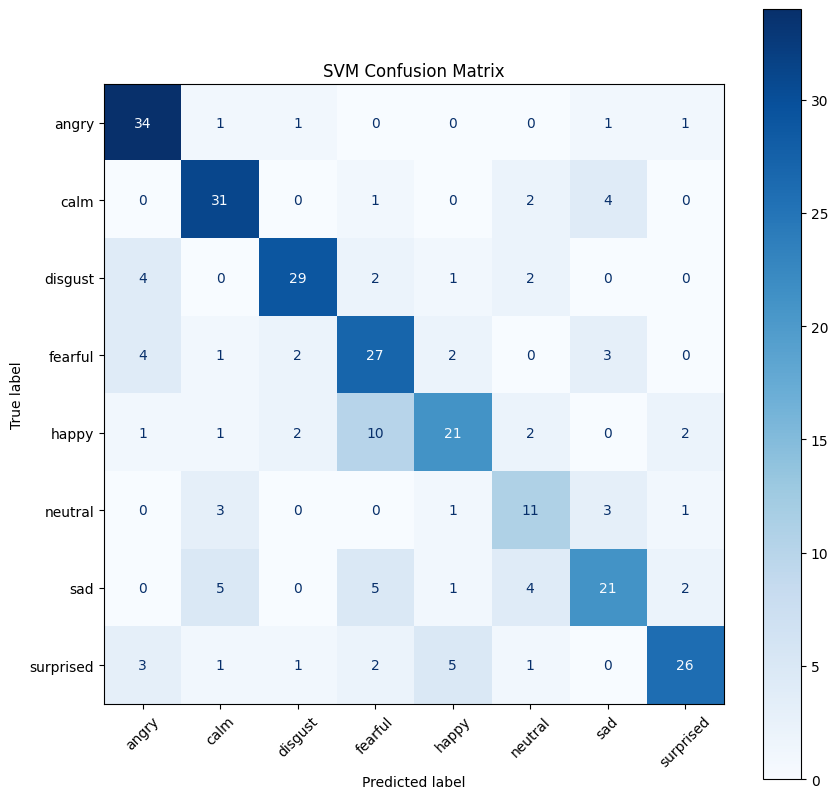

In [5]:
# --- Section 3: Final Evaluation and Saving ---
# ==============================================

y_pred_svm = best_svm.predict(x_test_scaled)
y_true_labels = y_test_final

print(f"\nFinal SVM Test Accuracy: {accuracy_score(y_true_labels, y_pred_svm):.4f}")

# Classification Report
target_names = [label for label, code in sorted(y_map.items(), key=lambda item: item[1])]
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_svm, target_names=target_names, zero_division=0))

# Confusion Matrix Plot
cm = confusion_matrix(y_true_labels, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
ax.set_title('SVM Confusion Matrix')
plt.show() 

In [6]:
# Saving the best model and scaler
# -----------------------------
MODELS_DIR = 'model'
os.makedirs(MODELS_DIR, exist_ok=True)

# Save the Best SVM Model
svm_model_path = os.path.join(MODELS_DIR, 'best_svm_model.pkl')
with open(svm_model_path, 'wb') as f:
    pickle.dump(best_svm, f)
print(f"\nBest SVM Model saved to {svm_model_path}")

# Save the Scaler (CRUCIAL for prediction on new data)
scaler_path = os.path.join(MODELS_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"StandardScaler saved to {scaler_path}")

# Save the Label Map (CRUCIAL for inverse prediction)
label_map_path = os.path.join(MODELS_DIR, 'emotion_label_map.pkl')
with open(label_map_path, 'wb') as f:
    pickle.dump(y_map, f)
print(f"Emotion Label Map saved to {label_map_path}")

print("\nSVM Training, Tuning, and Saving Complete.")


Best SVM Model saved to model\best_svm_model.pkl
StandardScaler saved to model\scaler.pkl
Emotion Label Map saved to model\emotion_label_map.pkl

SVM Training, Tuning, and Saving Complete.
